Python-moa (mathematics of arrays) is an approach to a high level tensor
compiler that is based on the work of [Lenore
Mullins](https://www.albany.edu/ceas/lenore-mullin.php) and her
[dissertation](https://www.researchgate.net/publication/308893116_A_Mathematics_of_Arrays).
A high level compiler is necessary because there are many optimizations
that a low level compiler such as `gcc` will miss. It is trying to solve
many of the same problems as other technologies such as the [taco
compiler](http://tensor-compiler.org/) and the [xla
compiler](https://www.tensorflow.org/xla). However, it takes a much
different approach than others guided by the following principles.

1.  What is the shape? Everything has a shape. scalars, vectors, arrays,
    operations, and functions.
2.  What are the given indicies and operations required to produce a
    given index in the result?

Having a compiler that is guided upon these principles allows for high
level reductions that other compilers will miss and allows for
optimization of algorithms as a whole. Keep in mind that MOA is **NOT**
a compiler. It is a theory that guides compiler development. Since
[python-moa](https://github.com/Quansight-Labs/python-moa) is based on
theory we get unique properties that other compilers cannot guarantee:

<!-- TEASER_END -->

 -   No out of bounds array accesses
 -   A computation is determined to be either valid or invalid at
     compile time
 -   The computation will always reduce to a deterministic minimal form
     (dnf) (see
     [church-rosser](https://en.wikipedia.org/wiki/Church%E2%80%93Rosser_theorem)
     property)
 -   All MOA operations are composable (including black box functions
     and
     [gufuncs](https://docs.scipy.org/doc/numpy-1.13.0/reference/c-api.generalized-ufuncs.html))
 -   Arbitrary high level operations will compile down to a minimal
     backend instruction set. If the shape and indexing of a given
     operation is known it can be added to python-moa.

## Frontend

Lenore Mullins originally developed a [moa
compiler](https://github.com/saulshanabrook/psi-compiler/) in the 90s
with programs that used a symbolic syntax heavily inspired by
[APL](https://en.wikipedia.org/wiki/APL_(programming_language))
([example
program](https://github.com/saulshanabrook/psi-compiler/blob/master/examples/ex1.m)).
This work was carried into python-moa initially with a lex/yacc compiler
with an example program below.

In [1]:
from moa.frontend import parse

context = parse('<0> psi (tran (A ^ <n m> + B ^ <k l>))')

Upon pursuing this approach it became apparent that MOA should not
require that a new syntax be developed since it is only a theory! So a
pythonic interface to MOA was developed that expressed the same ideas
which look much like the current numeric python libraries. Ideally MOA
is hidden from the user. The python-moa compiler is broken into several
pieces each which their own responsibilities: shape, DNF, and ONF.

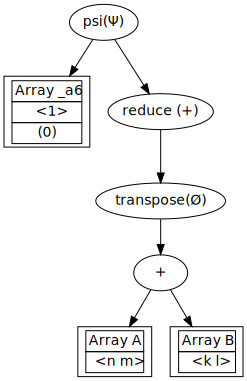

In [2]:
from moa.frontend import LazyArray

A = LazyArray(shape=('n', 'm'), name='A')
B = LazyArray(shape=('k', 'l'), name='B')

expression = (A + B).T.reduce('+')[0]
expression

## Shape Calculation

The shape calculation is responsible for calculating the shape at every
step of the computation. This means that operations have a shape. Note
that the compiler handles symbolic shapes thus the exact shape does not
need to be known, only the dimension. After the shape calculation step
we can guarantee that an algorithm is a valid program and there will be
no out of bound memory accesses. Making MOA extremely compelling for
[FPGAs](https://en.wikipedia.org/wiki/Field-programmable_gate_array) and
compute units with a minimal OS. If an algorithm makes it past this
stage and fails then it is an issue with the compiler not the algorithm.

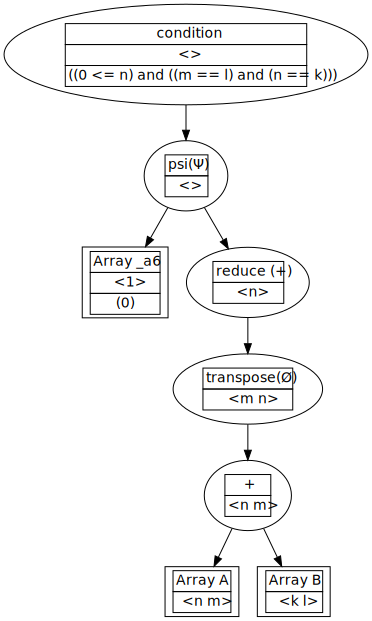

In [3]:
expression.visualize(stage='shape')

## Denotational Normal Form (DNF)

The DNF\'s responsibility is to reduce the high level MOA expression to
the minimal and optimal machine independent computation. This graph has
all of the indexing patterns of the computation and resulting shapes.
Notice that several operations disappear in this stage such a transpose
because transpose is simply index manipulation.

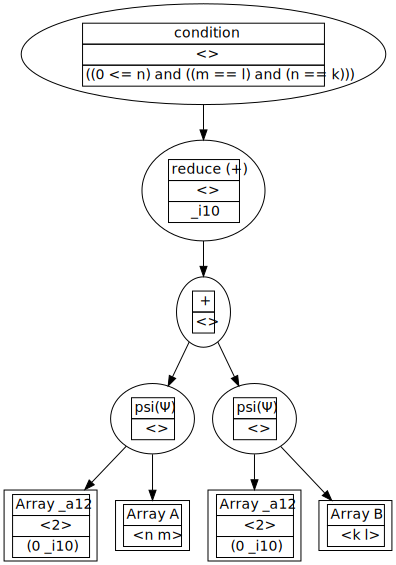

In [4]:
expression.visualize(stage='dnf')

## Operational Normal Form (ONF)

The ONF is the stage of the compiler that will have to be the most
flexible. At its current stage the ONF is a naive compiler that does not
perform many important optimizations such as [PSI
reduction](https://www.researchgate.net/publication/264758384_Effective_data_parallel_computation_using_the_Psi_calculus)
which reduces the number of loops in the calculation, loop ordering, and
minimize the number of accumulators. MOA has ideas of dimension lifting
which make parallization and optimizing for cache sizes much easier.
Additionally algorithms must be implemented differently for sparse,
column major, row major. The ONF stage is responsible for any
\"optimal\" machine dependent implementation. \"optimal\" will vary from
user to user and thus will have to allow for multiple programs: optimal
single core, optimal parallel, optimal gpu, optimal low memory, etc.

In [5]:
print(expression.compile(use_numba=True, include_conditions=False))



@numba.jit
def f(A, B):
    
    
    n = A.shape[0]
    
    m = A.shape[1]
    
    k = B.shape[0]
    
    l = B.shape[1]
    
    _a21 = numpy.zeros(())
    
    _a19 = numpy.zeros(())
    
    _a21 = 0
    
    for _i10 in range(0, m, 1):
        
        _a21 = (_a21 + (A[(0, _i10)] + B[(0, _i10)]))
    
    _a19[()] = _a21
    return _a19


## Performance

MOA excels at performing reductions and reducing the amount of actual
work done. You will see that the following algorithm only requires the
first index of the computation. Making the naive implementation `1000x`
more expensive for `1000x1000` shaped array. The following benchmarks
have been performed on my laptop with an intel i5-4200U. However, more
benchmarks are always available on the [Travis
CI](https://travis-ci.org/Quansight-Labs/python-moa) (these benchmarks
test python-moa\'s weaknesses). You will see with the benchmarks that if
**any** indexing is required MOA will be significantly faster unless you
hand optimize the numerical computations.

In [6]:
import numpy
import numba

n, m = 1000, 1000

exec(expression.compile(backend='python', use_numba=True, include_conditions=False))

A = numpy.random.random((n, m))
B = numpy.random.random((n, m))

Here we execute the MOA optimized code with the help of
[numba](https://github.com/numba/numba) which is a JIT LLVM compiler for
python.

In [7]:
%%timeit

f(A=A, B=B)

2.14 µs ± 6.76 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


The following numpy computation is obviously the worst case expression
that you could write but this brings up the point that often times the
algorithm is expressed differently than the implementation. This is one
of the problems that MOA hopes to solve.

In [8]:
%%timeit

(A + B).T.sum(axis=0)[0]

2.74 ms ± 29.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We notice that even with the optimized version MOA is faster. This is
mostly due to the transpose operation the numpy performs that we have no
way around.

In [9]:
%%timeit

(A[0] + B[0]).T.sum(axis=0)

6.67 µs ± 91.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Conclusions
-----------

I hope that this walk through has shown the promising results that the
MOA theory can bring to tensor computations and the python ecosystem as
a whole. Please feel free to try out the project at [Quansight
Labs/python-moa](https://github.com/Quansight-Labs/python-moa). I hope
that this work can allow for the analysis and optimization of algorithms
in a mathematically rigorous way which allows users to express their
algorithms in an implementation independent manner.